# **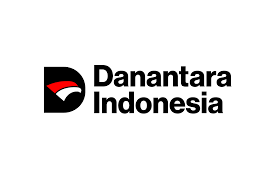**

---



# **Import Libraries**

In [3]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import time  # Added for timing


# --- NLP Libraries ---
# Using Transformers for primary sentiment analysis

from transformers import pipeline
TRANSFORMERS_AVAILABLE = True
import nltk
nltk.download('stopwords') # Added to download stopwords
from nltk.corpus import stopwords
stopwords.words('indonesian')

# Using Scikit-learn for TF-IDF baseline and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from tqdm.auto import tqdm
tqdm.pandas() # Integrate tqdm with pandas apply
TQDM_AVAILABLE = True

from wordcloud import WordCloud
WORDCLOUD_AVAILABLE = True

# Ignore specific warnings if they clutter the output (optional)
warnings.filterwarnings("ignore", category=UserWarning, module='transformers.modeling_utils')
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore some pandas/sklearn warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Configuration**

In [4]:

# File path for the input CSV
CSV_FILE_PATH = "Data Sentiment.csv"

# Column containing the main text data
TEXT_COLUMN = 'full_text'
# Column containing the creation timestamp
TIMESTAMP_COLUMN = 'created_at'

# --- Model Configuration ---
# Primary sentiment model (Indonesian RoBERTa based)
SENTIMENT_MODEL_HF = "w11wo/indonesian-roberta-base-sentiment-classifier"

NLTK_AVAILABLE = True
TRANSFORMERS_AVAILABLE = True

# **Preprocessing Configuration**

In [5]:

# Basic normalization dictionary
NORMALIZATION_DICT = {
    'yg': 'yang', 'utk': 'untuk', 'dgn': 'dengan', 'kalo': 'kalau', 'klo': 'kalau',
    'tdk': 'tidak', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'enggak': 'tidak', 'nggak': 'tidak',
    'jg': 'juga', 'aja': 'saja', 'blm': 'belum', 'sdh': 'sudah', 'udah': 'sudah',
    'krn': 'karena', 'karna': 'karena', 'bgt': 'banget', 'skrg': 'sekarang',
    'lg': 'lagi', 'sy': 'saya', 'gua': 'saya', 'gw': 'saya', 'gue': 'saya',
    'lu': 'kamu', 'loe': 'kamu', 'dlm': 'dalam', 'dg': 'dengan', 'dr': 'dari',
    'omom': 'bicara', 'omong': 'bicara', 'tp': 'tapi', 'ttp': 'tetap',
    'sm': 'sama', 'kyk': 'kayak', 'gmn': 'bagaimana', 'gimana': 'bagaimana',
    'sby': 'sby', 'jokowi': 'jokowi', 'prabowo': 'prabowo',
    'danantara': 'danantara', 'bumn': 'bumn', 'korupsi': 'korupsi',
    'investasi': 'investasi', 'ekonomi': 'ekonomi', 'duit': 'uang',
    'fufufafa': '',
    'wkwkwk': '', 'wkwk': '', 'haha': '', 'hehe': '',
    'anjay': '', 'anjir': '', 'asuu': '', 'kontol': '', 'babiq': ''
}

# Stopwords setup (only used for TF-IDF / WordCloud cleaning)
INDONESIAN_STOPWORDS = set()
INDONESIAN_STOPWORDS = set(stopwords.words('indonesian'))
additional_stopwords = {
        'danantara', 'bangun', 'negeri', 'terpercaya', 'bpi', 'daya', 'anagata', 'nusantara',
        'sby', 'jokowi', 'prabowo', 'presiden', 'akan', 'nya', 'rp', 'triliun', 't',
        'februari', 'copy', 'indonesia', 'lebih', 'bisa', 'jadi', 'untuk', 'akan', 'ini',
        'http', 'https', 'com', 'co', 'status', 'oleh', 'karena', 'juga', 'sebagai', 'agar',
        'dengan', 'yang', 'pada', 'dari', 'ke', 'di', 'itu', 'tidak', 'pak', 'dan', 'atau',
        'ada', 'tak', 'hal', 'telah', 'tsb', 'kata', 'utk', 'dgn', 'ri', 'dpr', 'kpk', 'bpk',
        'rp', 'triliun', 'usd', 'pukul', 'wib', 'istana', 'kepresidenan', 'jakarta', 'resmi',
        'sekarang', 'masih', 'buat', 'udah', 'lagi', 'mau', 'banget', 'nih', 'kok', 'apa',
        'via', 'cek', 'kak', 'nder', 'nih', 'mah', 'si', 'yaa', 'ya', 'gini', 'gitu', 'aja',
        'eh', 'loh', 'dah'
    }
INDONESIAN_STOPWORDS.update(additional_stopwords)

# **Data Loading**

In [6]:
print("--- Starting Data Loading ---")
df = pd.read_csv(CSV_FILE_PATH)
print(f"Successfully loaded '{CSV_FILE_PATH}'")
print(f"Initial dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nChecking for missing values:")
print(df.isnull().sum())
print("\nBasic Data Info:")
df.info()
print("--- Data Loading Finished ---")

--- Starting Data Loading ---
Successfully loaded 'Data Sentiment.csv'
Initial dataset shape: 32114 rows, 17 columns

Checking for missing values:
conversation_id_str            0
created_at                     0
favorite_count                 0
full_text                      0
id_str                         0
image_url                  23107
in_reply_to_screen_name    14713
lang                           0
location                   16262
quote_count                    0
reply_count                    0
retweet_count                  0
tweet_url                      0
user_id_str                    0
username                       0
sentiment_label                0
sentiment_score                0
dtype: int64

Basic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32114 entries, 0 to 32113
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      32114 non-null

# **Remove Redundant**

In [7]:
print("\n--- Removing Duplicate Tweets ---")
if 'full_text' in df.columns:
    initial_rows = df.shape[0]
    # Consider duplicates based on the core text content, keep the first occurrence
    df.drop_duplicates(subset=['full_text'], keep='first', inplace=True)
    final_rows = df.shape[0]
    removed_count = initial_rows - final_rows
    print(f"Removed {removed_count} duplicate tweets based on 'full_text'.")
    print(f"Dataset shape after removing duplicates: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    print("Column 'full_text' not found. Skipping duplicate removal.")
print("--- Duplicate Removal Finished ---")


--- Removing Duplicate Tweets ---
Removed 3195 duplicate tweets based on 'full_text'.
Dataset shape after removing duplicates: 28919 rows, 17 columns
--- Duplicate Removal Finished ---


In [8]:

print("\n--- Starting Preprocessing ---")

# Convert 'created_at' to datetime, coercing errors
if 'created_at' in df.columns:
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    rows_before_dropna = df.shape[0]
    df.dropna(subset=['created_at'], inplace=True) # Drop rows where date conversion failed
    rows_after_dropna = df.shape[0]
    if rows_before_dropna > rows_after_dropna:
        print(f"Dropped {rows_before_dropna - rows_after_dropna} rows due to invalid 'created_at' values.")
else:
    print("Warning: 'created_at' column not found. Skipping datetime conversion.")

# Fill missing text data (use .loc to avoid SettingWithCopyWarning)
text_cols_to_fill = ['full_text', 'in_reply_to_screen_name', 'location']
for col in text_cols_to_fill:
    if col in df.columns:
        df.loc[:, col] = df[col].fillna('')
    else:
        print(f"Warning: Column '{col}' not found. Skipping fillna.")

# --- Text Preprocessing Functions ---
def normalize_text(text):
    """Applies normalization using the dictionary."""
    if not isinstance(text, str): # Handle potential non-string data
        return ''
    words = text.split()
    normalized_words = [NORMALIZATION_DICT.get(word, word) for word in words]
    return ' '.join(normalized_words)

def clean_text_basic(text):
    """Basic cleaning: lowercase, remove URLs, mentions, numbers, extra whitespace."""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+', '', text) # Remove mentions
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s#]', '', text) # Remove punctuation, keeping letters, numbers, whitespace, and hashtags
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple whitespace with single space
    return text

def clean_text_for_tfidf_wc(text):
    """Cleaning specifically for TF-IDF/WordClouds: removes hashtags and stopwords."""
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    words = text.split()
    # Remove stopwords if NLTK is available
    if NLTK_AVAILABLE and INDONESIAN_STOPWORDS:
        filtered_words = [word for word in words if word not in INDONESIAN_STOPWORDS and len(word) > 2]
    else:
        filtered_words = [word for word in words if len(word) > 2] # Only remove short words if stopwords unavailable
    return ' '.join(filtered_words)

# --- Apply Preprocessing ---
# Check if 'full_text' exists before applying
if 'full_text' in df.columns:
    # 1. Normalize text
    print("Normalizing text...")
    df['normalized_text'] = df['full_text'].apply(normalize_text)
    # 2. Basic cleaning (for Transformer models)
    print("Applying basic cleaning...")
    df['processed_text_transformer'] = df['normalized_text'].apply(clean_text_basic)
    # 3. Advanced cleaning (for TF-IDF/WordClouds)
    print("Applying advanced cleaning (TF-IDF/WordCloud)...")
    df['processed_text_tfidf_wc'] = df['processed_text_transformer'].apply(clean_text_for_tfidf_wc)

    print("\nPreprocessing examples:")
    print(df[['full_text', 'processed_text_transformer', 'processed_text_tfidf_wc']].head())
else:
    print("Error: 'full_text' column not found. Cannot apply text preprocessing.")

print("--- Preprocessing Finished ---")


--- Starting Preprocessing ---
Normalizing text...
Applying basic cleaning...
Applying advanced cleaning (TF-IDF/WordCloud)...

Preprocessing examples:
                                           full_text  \
0  Investasi negara makin terarah gak ada cerita ...   
1  Danantara adalah alat pembangunan nasional den...   
2  Danantara mendorong ekonomi Indonesia untuk le...   
3  Sektor Pendidikan lebih worth it daripada Dana...   
4  Melalui Danantara ekosistem investasi nasional...   

                          processed_text_transformer  \
0  investasi negara makin terarah tidak ada cerit...   
1  danantara adalah alat pembangunan nasional den...   
2  danantara mendorong ekonomi indonesia untuk le...   
3  sektor pendidikan lebih worth it daripada dana...   
4  melalui danantara ekosistem investasi nasional...   

                             processed_text_tfidf_wc  
0  investasi negara terarah cerita buangbuang sumber  
1  alat pembangunan nasional mengawasi manfaatnya...  
2       

# **MAIN**

## **sentiment Analysis**

In [9]:
print("\n--- Starting Sentiment Analysis ---")

sentiment_model_to_use = None
sentiment_col_name = 'sentiment'  # Default column name
hf_success = False

# --- Method 1: Hugging Face Transformer (Primary) ---
if TRANSFORMERS_AVAILABLE:
    print(f"\nAttempting sentiment analysis with Hugging Face model: {SENTIMENT_MODEL_HF}")
    try:
        # Load the pipeline (try using device=0 if GPU is available and configured)
        sentiment_pipeline_hf = pipeline(
            "sentiment-analysis",
            model=SENTIMENT_MODEL_HF,
            device=0
        )
        print("Hugging Face pipeline initialized successfully.")

        def get_sentiment_hf(text):
            """Gets sentiment using the loaded HF pipeline."""
            if not text or pd.isna(text):
                return "Neutral"
            try:
                # Models like RoBERTa have a max sequence length (often 512)
                max_len = sentiment_pipeline_hf.model.config.max_position_embeddings - 2  # Account for special tokens
                truncated_text = text[:max_len]
                with warnings.catch_warnings():  # Suppress truncation warnings specifically
                    warnings.simplefilter("ignore")
                    result = sentiment_pipeline_hf(truncated_text)[0]

                # Map labels (adjust based on the specific model's output)
                label_map = {'positive': 'Positive', 'negative': 'Negative', 'neutral': 'Neutral'}
                sentiment_label = label_map.get(result['label'].lower(), 'Neutral')  # Default to Neutral
                return sentiment_label
            except Exception as e:
                return "Neutral"  # Return Neutral on error for a single tweet

        # Apply the function with tqdm progress bar
        print("Applying Hugging Face model to dataset (this can take a significant amount of time)...")
        df[sentiment_col_name] = df['processed_text_transformer'].progress_apply(get_sentiment_hf)
        print("Hugging Face sentiment analysis complete.")
        hf_success = True
        sentiment_model_to_use = SENTIMENT_MODEL_HF

    except Exception as e:
        print(f"\nERROR: Failed to initialize or run Hugging Face pipeline: {e}")
        print("The script will proceed without Transformer-based sentiment results.")
        hf_success = False
else:
    print("Skipping Hugging Face analysis as 'transformers' library is not available.")



--- Starting Sentiment Analysis ---

Attempting sentiment analysis with Hugging Face model: w11wo/indonesian-roberta-base-sentiment-classifier


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


Hugging Face pipeline initialized successfully.
Applying Hugging Face model to dataset (this can take a significant amount of time)...


  0%|          | 0/28919 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Hugging Face sentiment analysis complete.


# **Visualization**


--- Starting Quantitative Analysis & Visualization ---
Analyzing sentiments based on model: w11wo/indonesian-roberta-base-sentiment-classifier

Overall Sentiment Distribution:
sentiment
Neutral     11215
Negative     9893
Positive     7811
Name: count, dtype: int64

Overall Sentiment Percentages:
sentiment
Neutral     38.780732
Negative    34.209343
Positive    27.009924
Name: proportion, dtype: float64


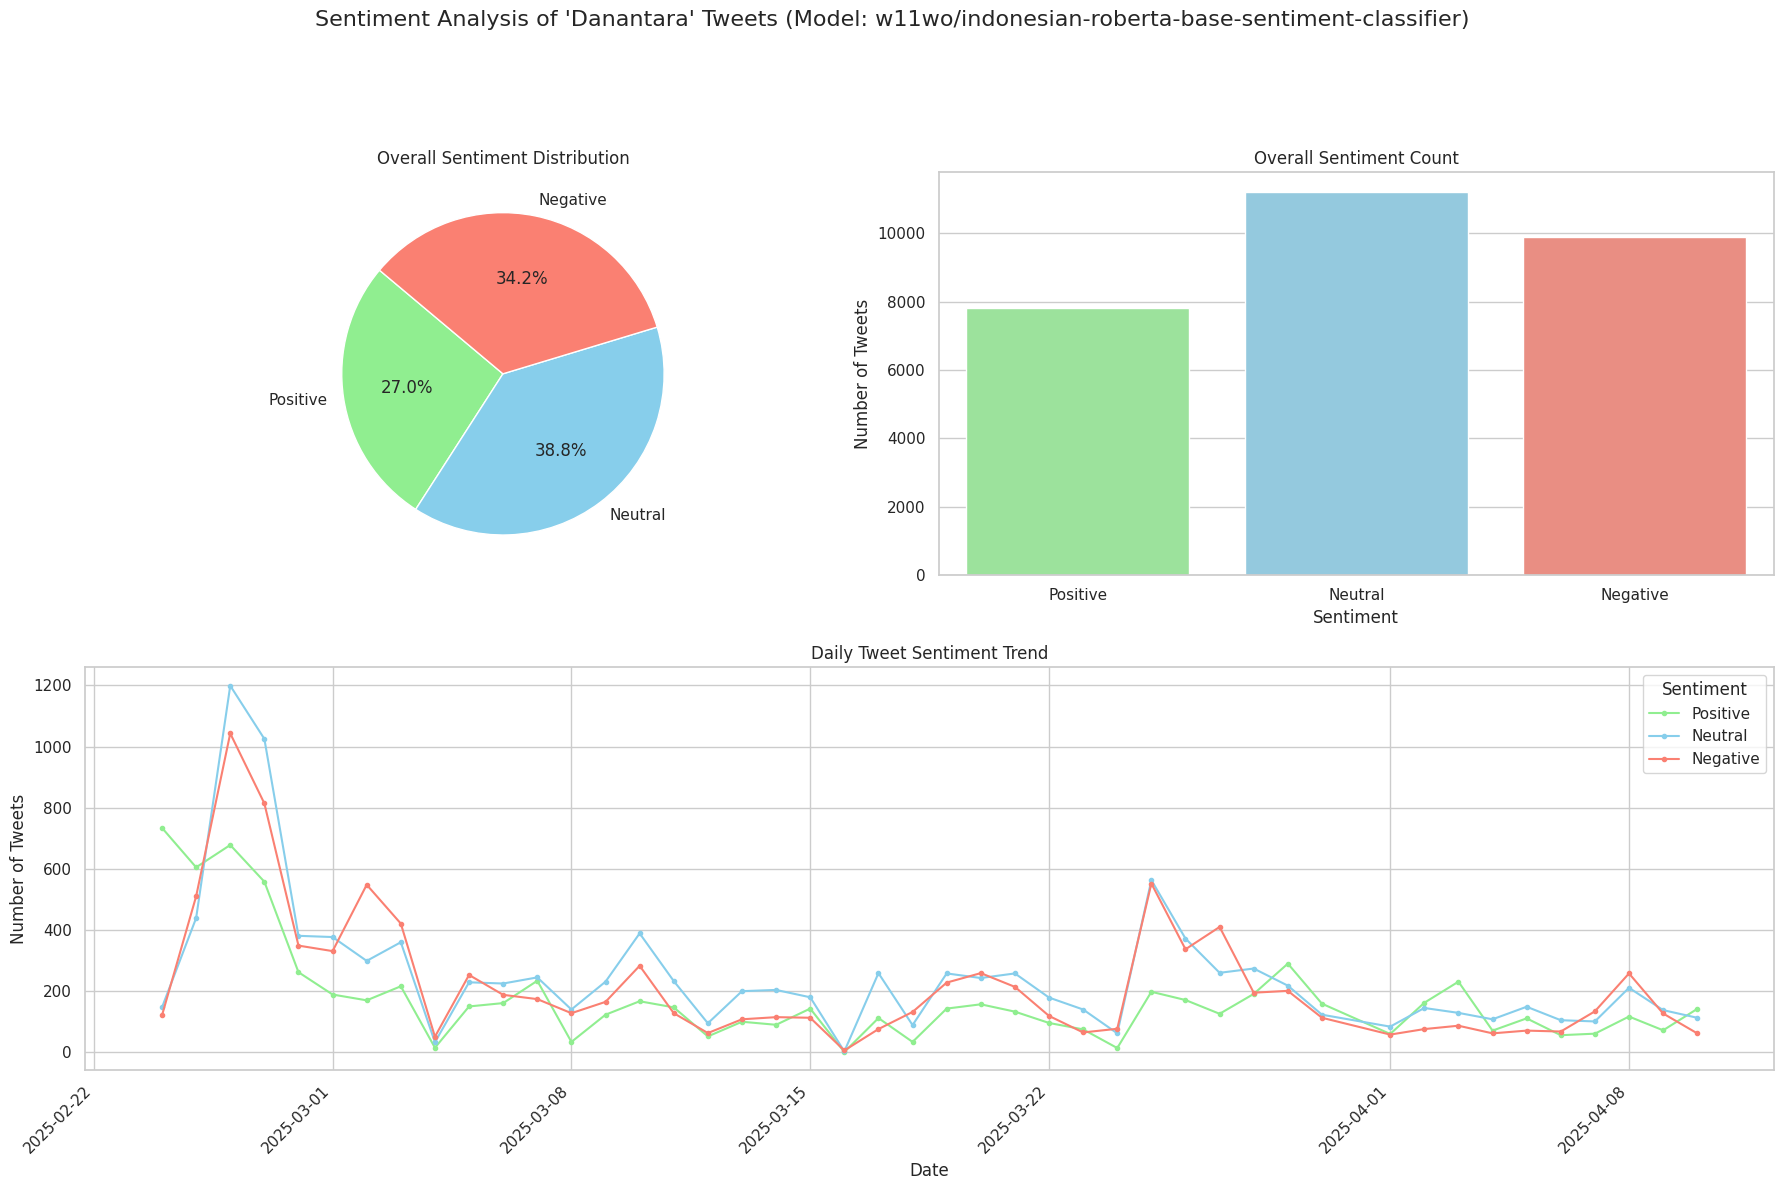

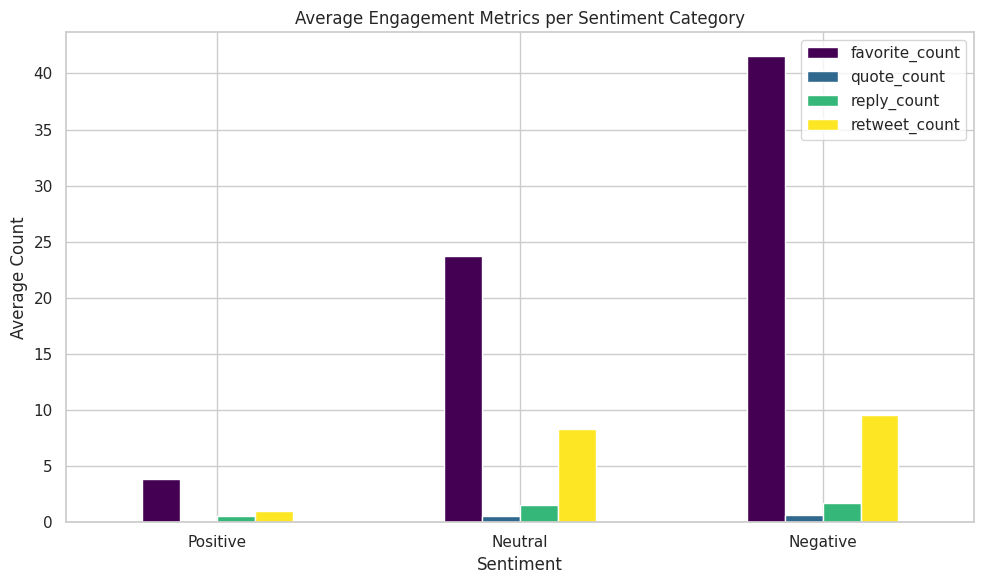


Generating Word Clouds...


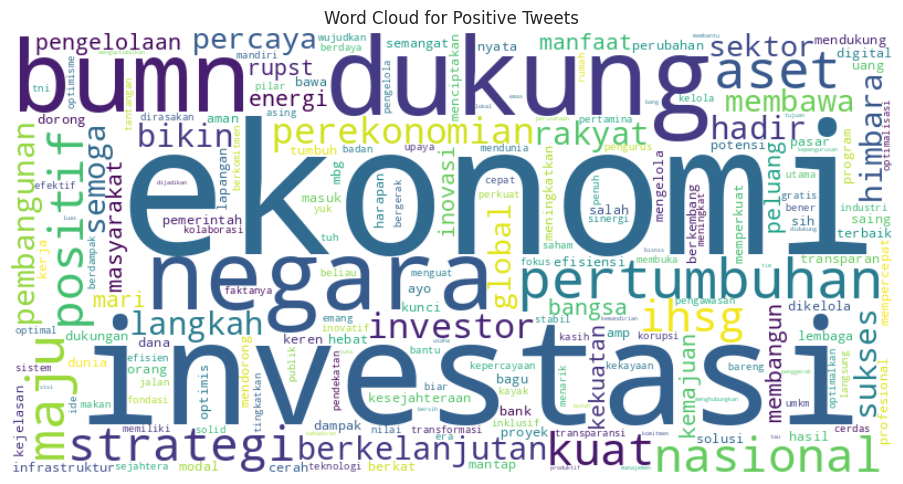

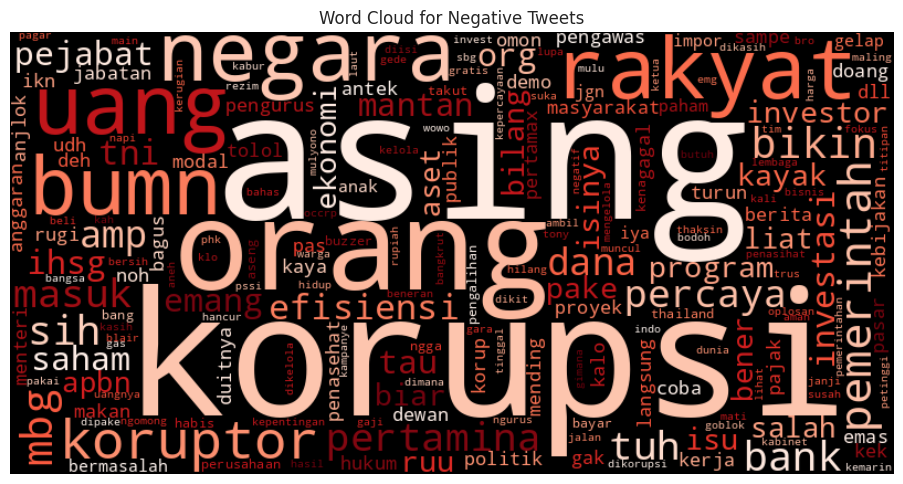

--- Quantitative Analysis & Visualization Finished ---


In [10]:
print("\n--- Starting Quantitative Analysis & Visualization ---")

# Check if sentiment analysis was successful before proceeding
if hf_success and sentiment_col_name in df.columns and df[sentiment_col_name].nunique() > 1:
    print(f"Analyzing sentiments based on model: {sentiment_model_to_use}")

    # Overall Sentiment Distribution
    sentiment_counts = df[sentiment_col_name].value_counts()
    sentiment_percentages = df[sentiment_col_name].value_counts(normalize=True) * 100
    print("\nOverall Sentiment Distribution:")
    print(sentiment_counts)
    print("\nOverall Sentiment Percentages:")
    print(sentiment_percentages)

    # --- Visualization ---
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 12))
    plt.suptitle(f"Sentiment Analysis of 'Danantara' Tweets (Model: {sentiment_model_to_use})", fontsize=16, y=1.02)

    # Define colors consistently
    colors = {'Positive': 'lightgreen', 'Negative': 'salmon', 'Neutral': 'skyblue'}
    sentiment_order = ['Positive', 'Neutral', 'Negative'] # Consistent order

    # Plot 1: Overall Sentiment Distribution (Pie Chart)
    plt.subplot(2, 2, 1)
    # Ensure counts are reindexed for consistent color mapping if a category is missing
    sentiment_counts_reindexed = sentiment_counts.reindex(sentiment_order, fill_value=0)
    pie_colors = [colors.get(label, 'gray') for label in sentiment_counts_reindexed.index]
    plt.pie(sentiment_counts_reindexed, labels=sentiment_counts_reindexed.index, autopct='%1.1f%%', startangle=140, colors=pie_colors)
    plt.title('Overall Sentiment Distribution')
    plt.ylabel('')

    # Plot 2: Overall Sentiment Distribution (Bar Chart)
    plt.subplot(2, 2, 2)
    bar_colors = [colors.get(label, 'gray') for label in sentiment_order]
    # Use reindexed counts for the bar plot as well
    sns.barplot(x=sentiment_counts_reindexed.index, y=sentiment_counts_reindexed.values, palette=bar_colors, order=sentiment_order)
    plt.title('Overall Sentiment Count')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Tweets')

    # Plot 3: Sentiment Trends Over Time
    plt.subplot(2, 1, 2)
    if 'created_at' in df.columns and not df['created_at'].isnull().all():
        df_time = df.set_index('created_at')
        # Resample daily and count sentiments
        daily_sentiment = df_time.groupby([pd.Grouper(freq='D'), sentiment_col_name]).size().unstack(fill_value=0)
        # Ensure all sentiment categories are present for plotting and use consistent order
        for sentiment_cat in sentiment_order:
            if sentiment_cat not in daily_sentiment.columns:
                daily_sentiment[sentiment_cat] = 0
        daily_sentiment = daily_sentiment[sentiment_order] # Enforce order

        line_colors = [colors.get(label, 'gray') for label in daily_sentiment.columns]
        daily_sentiment.plot(kind='line', marker='.', linestyle='-', ax=plt.gca(), color=line_colors)
        plt.title('Daily Tweet Sentiment Trend')
        plt.xlabel('Date')
        plt.ylabel('Number of Tweets')
        plt.xticks(rotation=45)
        plt.legend(title='Sentiment')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    else:
        plt.text(0.5, 0.5, "'created_at' column missing or invalid for time trend plot.", ha='center', va='center')
        plt.title('Daily Tweet Sentiment Trend (Unavailable)')
        plt.xlabel('Date')
        plt.ylabel('Number of Tweets')


    # Plot 4: Engagement Metrics per Sentiment (Separate Figure)
    plt.figure(figsize=(10, 6)) # New figure for engagement plots
    engagement_cols = ['favorite_count', 'quote_count', 'reply_count', 'retweet_count']
    # Check if engagement columns exist
    existing_engagement_cols = [col for col in engagement_cols if col in df.columns]
    if existing_engagement_cols:
        sentiment_engagement = df.groupby(sentiment_col_name)[existing_engagement_cols].mean().reindex(sentiment_order)
        sentiment_engagement.plot(kind='bar', colormap='viridis', ax=plt.gca()) # Use plt.gca() to plot on current figure
        plt.title('Average Engagement Metrics per Sentiment Category')
        plt.xlabel('Sentiment')
        plt.ylabel('Average Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, "Engagement columns not found for plotting.", ha='center', va='center')
        plt.title('Average Engagement Metrics (Unavailable)')
        plt.xlabel('Sentiment')
        plt.ylabel('Average Count')

    plt.show() # Show the first set of plots

    # --- Word Clouds (Separate Figures) ---
    if WORDCLOUD_AVAILABLE and 'processed_text_tfidf_wc' in df.columns:
        print("\nGenerating Word Clouds...")

        # Positive Word Cloud
        positive_text = " ".join(tweet for tweet in df[df[sentiment_col_name] == 'Positive']['processed_text_tfidf_wc'] if isinstance(tweet, str) and tweet)
        if positive_text:
            try:
                wordcloud_pos = WordCloud(width=800, height=400, background_color ='white', collocations=False).generate(positive_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud_pos, interpolation='bilinear')
                plt.axis("off")
                plt.title('Word Cloud for Positive Tweets')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not generate positive word cloud: {e}")
        else:
            print("No positive text found for word cloud generation.")

        # Negative Word Cloud
        negative_text = " ".join(tweet for tweet in df[df[sentiment_col_name] == 'Negative']['processed_text_tfidf_wc'] if isinstance(tweet, str) and tweet)
        if negative_text:
            try:
                wordcloud_neg = WordCloud(width=800, height=400, background_color ='black', colormap='Reds', collocations=False).generate(negative_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud_neg, interpolation='bilinear')
                plt.axis("off")
                plt.title('Word Cloud for Negative Tweets')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not generate negative word cloud: {e}")
        else:
            print("No negative text found for word cloud generation.")
    else:
        if not WORDCLOUD_AVAILABLE:
            print("WordCloud library not installed. Skipping word cloud generation.")
        elif 'processed_text_tfidf_wc' not in df.columns:
             print("Column 'processed_text_tfidf_wc' not found. Skipping word cloud generation.")

else:
    print("\nSentiment analysis was not performed or resulted in no sentiment data.")
    if not hf_success:
        print("Reason: Hugging Face pipeline failed or was skipped.")
    elif sentiment_col_name not in df.columns:
        print(f"Reason: Sentiment column '{sentiment_col_name}' not found in DataFrame.")
    elif df[sentiment_col_name].nunique() <= 1:
        print(f"Reason: Sentiment column '{sentiment_col_name}' has only one unique value.")

print("--- Quantitative Analysis & Visualization Finished ---")